# Gas Price Prediction with ARIMA Model

This notebook contains the ARIMA model used in the thesis project. The experiment includes two extracted datasets for a predefined gas station. The first dataset contains the daily maximum prices while the other contains data of hourly granularity. <br>The datasets are modeled with ARIMA and SARIMA respectively. The models are embedded into a loop to perform rolling forecasts. This method shall ensure accurate predictions based on the entire price history of the dataset. The models are built for direct comparison to recurrent neural networks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMAResults
import sklearn.metrics as metrics
from math import sqrt

# Metrics

The following metrics are used:
+ Mean Absolute Error               **(MAE)**
+ Mean Squared Error                **(MSE)**
+ Root Mean Squared Error           **(RMSE)**
+ Mean Absolute Percentage Error    **(MAPE)** $*$
+ Mean Percentage Error              **(MPE)**

*$*$ Function **mean_absolute_percentage_error** has been adapted from **[2]**. **mean_percentage_error** is based on this.*


In [2]:
def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( y_true != y_pred ) *100

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def print_metrics(prediction,target, rnd):
    
    if rnd == True: #if rounded data is investigated
        
        #cast to int does not harm data as it is already rounded when passed to function; 
        #cast is not necessary, but performed for completeness.
        prediction = np.asarray(prediction)
        prediction = prediction.astype(np.int64) 
        prediction = prediction.reshape(target.shape)
        
    else: #else original predictions are investigated
        
        prediction = np.asarray(prediction)
        prediction = prediction.reshape(target.shape)
        target = target.astype(np.float64)
    
    mae  = metrics.mean_absolute_error(target[:len(prediction)-1], prediction[1:]) 
    mse  = metrics.mean_squared_error(target[:len(prediction)-1], prediction[1:])
    msle = metrics.mean_squared_log_error(target[:len(prediction)-1], prediction[1:])
    mpe = mean_percentage_error(target[:len(prediction)-1], prediction[1:])
    mape = mean_absolute_percentage_error(target[:len(prediction)-1], prediction[1:])
    
    print("Mean Absolute Error: ", mae, sep="\t\t")
    print("Mean Squared Error: ", mse, sep="\t\t")
    print("Root Mean Squared Error: ", np.sqrt(mse), sep="\t")
    print("Mean Abs. Percentage Error: ", mape, sep="\t")
    print("Mean Percentage Error: ", mpe, sep="\t\t")

# Model Building

## 1. Data Loading
In the following example, a preprocessed gas price dataset is used. The data contains the daily maximum prices in the period from 06-2014 - 05-2016. The dataset has been extracted from **[1]**.

In [5]:
df = pd.read_csv('../Data/First_station_daily_maximum.csv', sep = ';')

In [6]:
df.head()

,max_date,stid,max
0,2014-06-08,105307c4-8562-45e4-9cc2-a04ef4a19400,152
1,2014-06-09,105307c4-8562-45e4-9cc2-a04ef4a19400,163
2,2014-06-10,105307c4-8562-45e4-9cc2-a04ef4a19400,164
3,2014-06-11,105307c4-8562-45e4-9cc2-a04ef4a19400,164
4,2014-06-12,105307c4-8562-45e4-9cc2-a04ef4a19400,165


In [7]:
df.isnull().values.any()

False

# 2. Data Preparation

In [8]:
df.dtypes

max_date    object
stid        object
max          int64
dtype: object

#### Step 2.1: Prepare dataframe
At this point, unnecessary columns are dropped.

In [9]:
df['max_date'] = pd.to_datetime(df['max_date'])

In [10]:
df = df.set_index('max_date');

In [11]:
df = df.drop('stid', axis=1)

#### Step 2.2: First visual inspection
A first visualization gives useful insights into the time series. The plot shows <BR>

* Indicators of a seasonal pattern.
* Possible outliers.
* Increasing volatility of prices past Oct 2015.

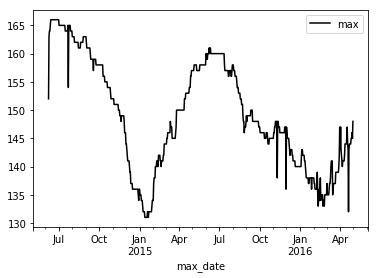

In [12]:
df.plot(color='k')
plt.show()

In [13]:
df.describe()

,max
count,693.000000
mean,149.101010
std,9.669759
min,131.000000
25%,141.000000
50%,148.000000
75%,158.000000
max,166.000000


## 3. Test for Stationarity

This function performs the Augmented Dickey-Fuller-test and prints out its statistics. The ADF-test is a frequently used method to determine the stationarity of a time series and thus the correct order of differencing (d). <br>
The function plots the time series, and additonally gives useful insigths by plotting the rolling mean. Window size is fixed to 7 by default.

Function **test_stationarity** has been adapted from **[3]**. *(modified)*

In [14]:
def test_stationarity(ts, full):
    
    
    if full == True: #if additional plot is needed

        #Determing rolling statistics
        rolmean = pd.rolling_mean(ts, window=7)

        #Plot rolling statistics:
        orig = plt.plot(ts, color='k',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')

        width = 10
        length = 6

        plt.legend(loc='best')
        plt.title('Rolling Mean')
        plt.rcParams['figure.figsize'] = (width, length)
        plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(ts.iloc[:,0].values, autolag=None)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ( dfoutput )

#### Step 3.1: Check for stationarity

At this point, the stationarity of the time series must be investigated. The reuslt of the ADF-test shows that the p-value is 0.24 (= 24%). Thus, the $h_0$ of remaining unit roots cannot be rejected. The $h_0$ can only be rejected if the p-value is less or equal to 0.05 (= 5%). <BR> <BR>
As a result, the time series must be differenced.

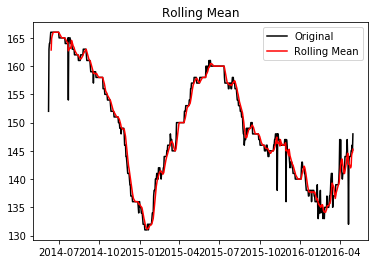

Results of Dickey-Fuller Test:
Test Statistic                  -2.094585
p-value                          0.246698
#Lags Used                      20.000000
Number of Observations Used    672.000000
Critical Value (1%)             -3.440119
Critical Value (5%)             -2.865851
Critical Value (10%)            -2.569066
dtype: float64


In [15]:
test_stationarity(df, True)

#### Step 3.2: Compute first differences
Differencing is a built-in function in pandas. Differencing gets applied by computing the first differences  $\hat y_t = y_t - y_{t-1} $ for all observations. <br>
The original series gets shortened by the last observation. For this reason, the resulting **NA** value gets dropped.

In [16]:
ts_diff = df.diff()

In [17]:
ts_diff.isnull().values.any()

True

In [18]:
ts_diff = ts_diff.dropna()

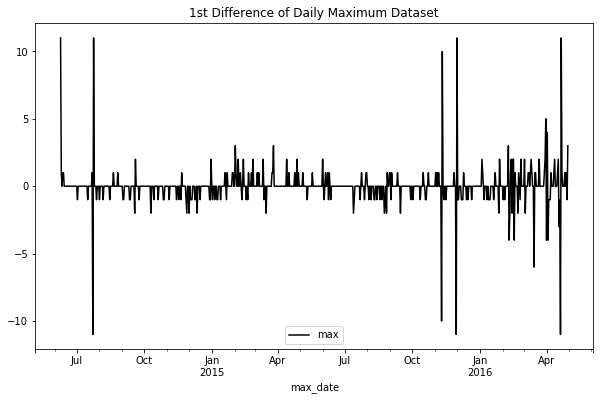

In [19]:
ts_diff.plot(color='k')
plt.title('1st Difference of Daily Maximum Dataset')
plt.show()

#### Step 3.3: Check for stationarity (again)

After that, the series of first differences is tested for stationarity. The result shows, that the p-value is very close to zero. In addition to that, the Test Statistic is smaller than the Critical Vlaue (1%). Therefore, the $h_0$ can be rejected. <br><br>
The time series is now stationary. For the ARIMA model, an **order d = 1** is needed.

In [20]:
test_stationarity(ts_diff, False)

Results of Dickey-Fuller Test:
Test Statistic                  -4.425580
p-value                          0.000267
#Lags Used                      20.000000
Number of Observations Used    671.000000
Critical Value (1%)             -3.440133
Critical Value (5%)             -2.865857
Critical Value (10%)            -2.569069
dtype: float64


## 4. Decomposition

By decomposing the time series one can detect certain characteristics of its parts. In this decomposition plot, a seasonality of 30 days is present. This seasonality is not observable in the original dataset and thus it might rather be assumed by the decomposition function of statsmodels. With regards to the time series plot depicted above, there is rather an annual seasonality. However, the decomposition plot shows a white noise process.<br><br>

In [21]:
decomposition = seasonal_decompose(df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


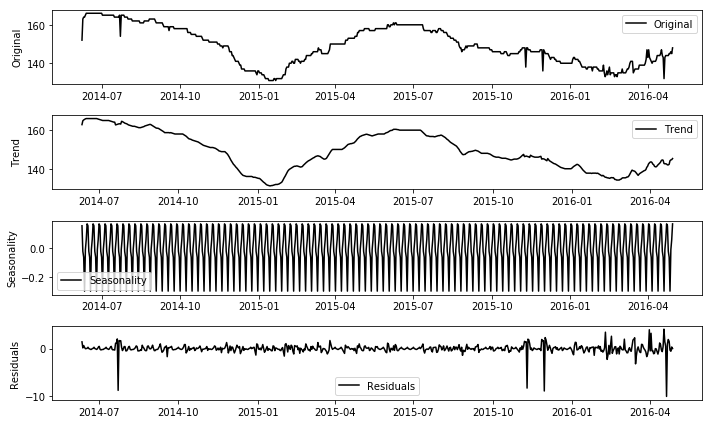

In [22]:
plt.subplot(411)
plt.plot(df, label='Original', color='k')
plt.ylabel('Original')
plt.legend()
plt.subplot(412)
plt.plot(trend, label='Trend', color='k')
plt.ylabel('Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='k')
plt.ylabel('Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(residual, label='Residuals', color='k')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Determine Model Orders p and q
Here, the ACF and PACF are computed. For this reason, the differenced time series gets investigated to determine the remaining ARIMA model parameter.

In [23]:
lag_acf = acf(ts_diff, nlags=120)
lag_pacf = pacf(ts_diff, nlags=120) #, method='ols'

In [24]:
acf_df  = pd.DataFrame(lag_acf[0:20])
pacf_df = pd.DataFrame(lag_pacf[0:20])

#### 5.1 Plot ACF

The ACF plot reveals that there is a significant early autocorrelations at **lag one**.

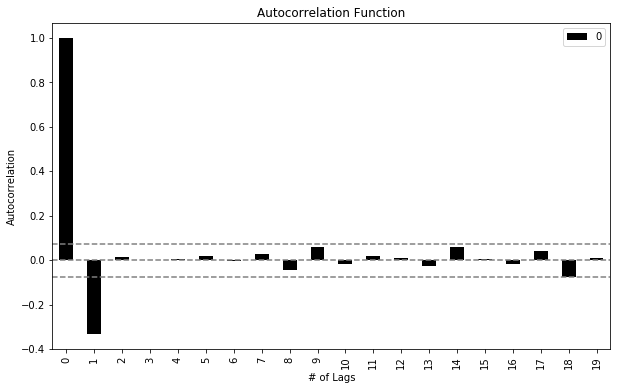

In [25]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
acf_df.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')
                        
plt.title('Autocorrelation Function')
plt.xlabel('# of Lags')
plt.ylabel('Autocorrelation')
plt.show()

#### 5.2 Plot PACF
Simultanously to the ACF, the PACF plot shows a negative partial autocorrelation at **lag one**. (and two) <br><br>
Combining the observations of ACF and PACF plot, an **order q = 1** appears to be sufficient.

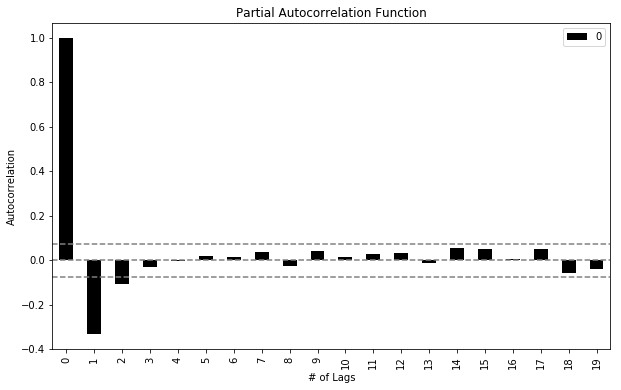

In [26]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
pacf_df.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')

plt.title('Partial Autocorrelation Function')
plt.xlabel('# of Lags') 
plt.ylabel('Autocorrelation')
plt.show()

## 6. Rolling Forecast with ARIMA

Rolling forecast of ARIMA model enables accurate multi-step predictions without including additional terms (e.g. seasonality) to the model. For gas price predictions, this method is even more suitable. In general, gas prices are volatile and thus long term forecasts are less reliable. <br><br>

For the daily dataset, the model orders ARIMA(0,1,1) were identified. <br><br>

The **following code** has been adapted from **[4]**. *(modified)*

In [27]:
X = df.values
X = X.astype('float64')
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
predictions_rnd = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()             
    output = model_fit.forecast()
    yhat_rnd = np.rint(output[0])
    yhat = output[0]
    predictions.append(yhat)
    predictions_rnd.append(yhat_rnd)
    obs = test[t]
    history.append(obs)

#### 6.1. Print AIC value
The Akaike Information Criterion is a measure of model quality. AIC is used to compare different models.

In [28]:
model_fit.aic

2405.5200140518623

#### 6.2. Plot predictions
The plot reveals that the model has problems with large spikes. However, rounding the predictions generally lead to more accurate results.

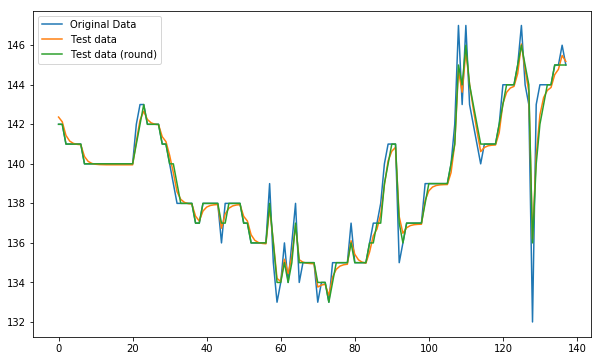

In [38]:
plt.plot(test[:len(predictions)-1], label='Original Data')
plt.plot(predictions[1:], label='Test data')
plt.plot(predictions_rnd[1:], label='Test data (round)')
plt.legend()
plt.show()

#### 6.3. Print metrics

In [30]:
print_metrics(predictions, test, False)

Mean Absolute Error: 		0.4156163981854163
Mean Squared Error: 		0.4858485926461372
Root Mean Squared Error: 	0.6970284016065179
Mean Abs. Percentage Error: 	0.2984842537811035
Mean Percentage Error: 		100.0


In [31]:
print_metrics(predictions_rnd, test, True)

Mean Absolute Error: 		0.34057971014492755
Mean Squared Error: 		0.5144927536231884
Root Mean Squared Error: 	0.7172815023567723
Mean Abs. Percentage Error: 	0.2441948462516167
Mean Percentage Error: 		28.26086956521739


## 7. Analysis of Residuals
Model adequacy can be determined by using the ACF on the model residuals. <br><br>

The Plots reveal, that there are significant autocorrelations remaining. Thus, there is information left. The model must be further improved.

In [32]:
resids = ARIMAResults.resid(model_fit)

In [33]:
lag_acf_resid = acf(resids, nlags=120)

In [34]:
acf_resid    = pd.DataFrame(lag_acf_resid[0:50])
acf_resid_1  = pd.DataFrame(lag_acf_resid[1:50])

In [35]:
def plot_acf(residuals, acf):

    sig_neg = -1.96/np.sqrt(len(residuals))
    sig_pos = 1.96/np.sqrt(len(residuals))
                       
                        
    acf.plot(kind ='bar', color='k')
    plt.axhline(y=0,       linestyle='--',color='gray')
    plt.axhline(y=sig_pos, linestyle='--',color='gray')
    plt.axhline(y=sig_neg, linestyle='--',color='gray')
                        
    plt.title('Autocorrelation Function')
    plt.xlabel('# of Lags')
    plt.ylabel('Autocorrelation')   
    plt.show()

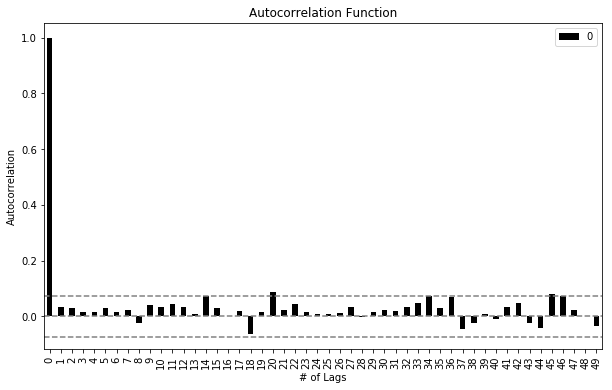

In [36]:
plot_acf(resids, acf_resid)

Without lag zero autocorrelation, the significant autocorrelations (20, 45) are more visible.

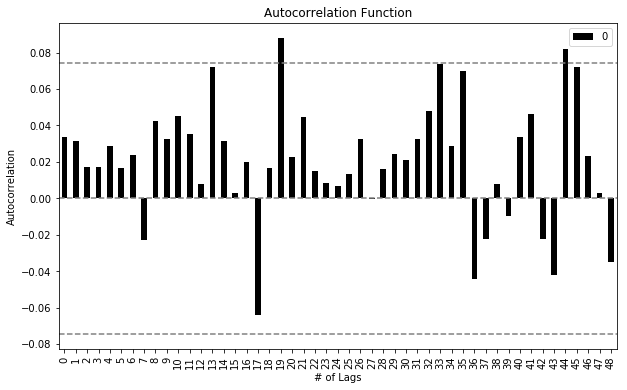

In [37]:
plot_acf(resids, acf_resid_1)

##### Dataset:

[1] Martin Kurz. *Historische Preisdaten*. 2017. Retrieved from https://creativecommons.tankerkoenig.de/ and licensed under CC-BY 4.0.

##### References:

[2] Antonín Hoskovec. *Mean absolute percentage error (MAPE) in Scikit-learn*. 2017. URL: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069#294069 (visited on 02/28/2018)

[3] Aarshay Jain. *A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)*. 2016. URL: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ (visited on 02/28/2018)

[4] Jason Brownlee. *How to Make Out-of-Sample Forecasts with ARIMA in Python*. 2017. URL: https://machinelearningmastery.com/make-sample-forecasts-arima-python/. *(visited on 02/28/2018)*

[5] The Pennsylvania State University. *STAT 510 – Applied Time Series Analysis*. 2018. URL: https://onlinecourses.science.psu.edu/stat510/. *(visited on 02/28/2018)*